In [142]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

### データを読み込む
- データ元：京都大学生存圏研究所のサイト内にある，「[解析値を中心に再構成したNetCDFデータ](http://database.rish.kyoto-u.ac.jp/arch/jmadata/gpv-netcdf.html)」からダウンロードしました。
- ファイル場所：[MSM-P/2023/](http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/netcdf/MSM-P/2023/)1205.nc
- `1205.nc`は100MB以上あるので，必要な風データのみを抽出して`1205_uv.nc`として保存しました。

In [2]:
data = xr.open_mfdataset('./1205_uv.nc').load()
data

<xarray.Dataset>
Dimensions:  (time: 8, p: 16, lat: 253, lon: 241)
Coordinates:
  * lon      (lon) float32 120.0 120.1 120.2 120.4 ... 149.6 149.8 149.9 150.0
  * lat      (lat) float32 47.6 47.5 47.4 47.3 47.2 ... 22.8 22.7 22.6 22.5 22.4
  * p        (p) float32 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * time     (time) datetime64[ns] 2023-12-05 ... 2023-12-05T21:00:00
Data variables:
    u        (time, p, lat, lon) float64 1.706 2.006 1.676 ... 16.86 16.89 16.91
    v        (time, p, lat, lon) float64 4.716 4.532 4.263 ... 2.434 2.226 1.951
Attributes:
    Conventions:  CF-1.0
    history:      created by create_1daync_msm_p.rb  2023-12-06

### 中身を見てみる

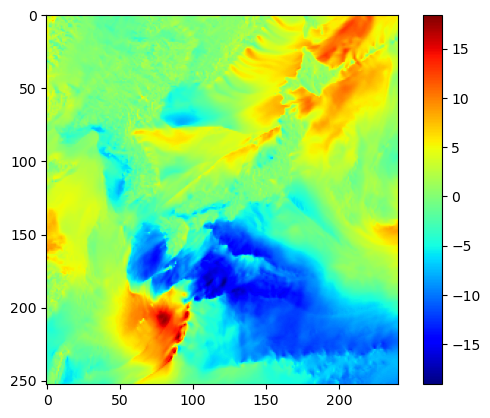

In [20]:
# data['u']やdata['v']の次元は(time, p, lat, lon)
# pは気圧面を表す
# uは東向き風速、vは北向き風速

# data['u'][0][0]は、0番目のtime(=2023/12/05 00:00(UTC)), 0番目のp(=1000hPa)の東向き風速のデータ
plt.imshow(data['u'][0][0], cmap='jet')
plt.colorbar()
plt.show()

### 渦度の計算

In [95]:
def dist(p1, p2):
    A = 6378137.0
    F = 1/298.257222101
    B = A*(1-F)
    lat1 = np.radians(p1[0])
    lon1 = np.radians(p1[1])
    lat2 = np.radians(p2[0])
    lon2 = np.radians(p2[1])
    phi1 = np.arctan2(B * np.tan(lat1), A)
    phi2 = np.arctan2(B * np.tan(lat2), A)
    X = np.arccos(np.sin(phi1) * np.sin(phi2) + np.cos(phi1) * np.cos(phi2) * np.cos(lon2 - lon1))
    drho = F/8 * ((np.sin(X) - X) * (np.sin(phi1) + np.sin(phi2))**2 / np.cos(X/2)**2 - (np.sin(X) + X) * (np.sin(phi1) - np.sin(phi2))**2 / np.sin(X/2)**2)
    rho = A * (X + drho)
    return rho

In [139]:
TIME = '2023-12-05T00:00:00'
P = 500

u = data['u'].sel(time=TIME, p=P).values
v = data['v'].sel(time=TIME, p=P).values

In [182]:
lon, lat = np.meshgrid(data['lon'].values, data['lat'].values)
zeta = np.zeros_like(u)

for i in range(1,lat.shape[0]-1):
    for j in range(1,lat.shape[1]-1):
        u1 = u[i+1][j]
        u2 = u[i-1][j]
        v1 = v[i][j-1]
        v2 = v[i][j+1]
        dx = dist((lat[i][j+1], lon[i][j+1]), (lat[i][j-1], lon[i][j-1]))
        dy = dist((lat[i+1][j], lon[i+1][j]), (lat[i-1][j], lon[i-1][j]))
        zeta[i][j] = (v2-v1)/dx - (u2-u1)/dy

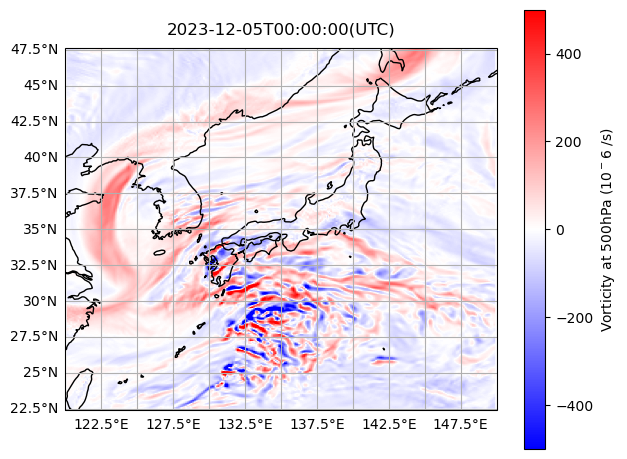

In [183]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(
    draw_labels=['left','bottom'],
    xlocs=np.arange(120, 150, 2.5),
    ylocs=np.arange(20, 50, 2.5),
)

plt.imshow(
    zeta*1e6, 
    cmap='bwr', vmax=500, vmin=-500,
    extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
    transform=ccrs.PlateCarree())
cbar = plt.colorbar()
cbar.set_label(f'Vorticity at {P}hPa ($10^{-6}$ /s)')
plt.title(TIME + '(UTC)')

plt.tight_layout()
plt.savefig('vorticity.png', dpi=300)
plt.show()